In [1]:
# импортируем бэкенд Agg из matplotlib для сохранения графиков на диск
import matplotlib
matplotlib.use("Agg")

In [2]:
# Подключаем необходимые модули и пакеты
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense
from tensorflow.keras.optimizers import SGD
from tqdm.keras import TqdmCallback
from imutils import paths
import plotly.graph_objects as go
import numpy as np
import json
import random
import pickle
import cv2
import os

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9156597638310391616,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5717884928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14386965056973257789
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6"]

In [4]:
path = './mapped_dataset'

# Загрузка изображений

## Начальная загрузка изображений

Просчитаем пути и label-ы для каждого изображения

In [5]:
filtered_image_paths = filter(lambda x: 
                              'flandre_scarlet' in x or 
                              'konpaku_youmu' in x or
                              'komeiji_koishi' in x, paths.list_images(path))

imagePaths = sorted(list(filtered_image_paths))
random.shuffle(imagePaths)

In [6]:
from tqdm import tqdm

data = []
labels = []

for imagePath in tqdm(imagePaths, total=len(imagePaths)):

	image = cv2.imread(imagePath) # загружаем изображение
	image = cv2.resize(image, (64, 64)).flatten() # меняем его разрешение на 64x64 пикселей (без учета соотношения сторон),
																								# сглаживаем его в 64x64x3=12 288 пикселей
	data.append(image) # добавляем в список

	label = imagePath.split(os.path.sep)[-2] 	# извлекаем метку класса из пути к изображению (метка класса зависит от имени папки)
	labels.append(label) # обновляем список меток

100%|██████████| 3722/3722 [04:15<00:00, 14.58it/s]


Нормализация данных

In [7]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

Разбиваем данные на обучающую и тестовую выборки, используя 75%. Данных для обучения и оставшиеся 25% для тестирования

In [8]:
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)

Конвертируем метки из целых чисел в векторы (для 2х классов при бинарной классификации вам следует использовать функцию Keras "to_categorical" вместо "LabelBinarizer" из scikit-learn, которая не возвращает вектор).

In [9]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# Варианты нейронной сети

### Методы для обработки

In [10]:
def trainModel(model, epochs, batch_size, opt):
	print("[INFO] training network...")
	model.compile(loss="categorical_crossentropy", optimizer=opt,
		metrics=["accuracy"])
	
	history = model.fit(trainX, trainY, validation_data=(testX, testY),
		epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[TqdmCallback(verbose=1)])
	
	fig = go.Figure()
	
	for key, _ in history.history.items():
		fig.add_trace(go.Scattergl(y=history.history[key],
			     name=key))
        
	fig.update_layout(height=500, width=700,
		   xaxis_title='Epoch',
		   yaxis_title='Loss')
	
	fig.update_xaxes(range=[0, epochs])
	fig.update_yaxes(range=[0, 2])

	fig.show()

	return model, history

### Все картинки
image: 64x64x3 ALL IMAGES

In [114]:
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Dense(2048, input_shape=(12288,), activation="relu")) 
model.add(Dense(1024, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

# Скорость обучения
INIT_LR = 0.01

# Количество эпох
EPOCHS = 100

# Размер батча
BATCH_SIZE = 500

model, history = trainModel(model, EPOCHS, BATCH_SIZE, SGD(INIT_LR))

[INFO] training network...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [115]:
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Dense(2048, input_shape=(12288,), activation="relu")) 
model.add(Dense(1024, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

# Скорость обучения
INIT_LR = 0.01

# Количество эпох
EPOCHS = 100

# Размер батча
BATCH_SIZE = 20

model, history = trainModel(model, EPOCHS, BATCH_SIZE, SGD(INIT_LR))

[INFO] training network...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [116]:
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Dense(2048, input_shape=(12288,), activation="relu"))
model.add(Dense(1024, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

# Скорость обучения
INIT_LR = 0.001

# Количество эпох
EPOCHS = 100

# Размер батча
BATCH_SIZE = 20

model, history = trainModel(model, EPOCHS, BATCH_SIZE, SGD(INIT_LR))

[INFO] training network...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(2048, input_shape=(12288,), activation="relu"))
model.add(Dense(1024, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

# Скорость обучения
INIT_LR = 0.01

# Количество эпох
EPOCHS = 50

# Размер батча
BATCH_SIZE = 400

model, history = trainModel(model, EPOCHS, BATCH_SIZE, Adam(INIT_LR))

[INFO] training network...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

### 3 класса ~4000 картинок
'flandre_scarlet'

'hakurei_reimu'

'komeiji_koishi'

image: 64x64x3 ALL IMAGES

In [ ]:
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(2048, input_shape=(12288,), activation="relu"))
model.add(Dense(1024, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

# Скорость обучения
INIT_LR = 0.01

# Количество эпох
EPOCHS = 50

# Размер батча
BATCH_SIZE = 400

model, history = trainModel(model, EPOCHS, BATCH_SIZE, Adam(INIT_LR))

[INFO] training network...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
# 'flandre_scarlet'
# 'hakurei_reimu'
# 'komeiji_koishi'

# image: 64x64x3 ALL IMAGES

from tensorflow.keras.optimizers import Adadelta

model = Sequential()
model.add(Dense(2048, input_shape=(12288,), activation="relu"))
model.add(Dense(1024, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

# Скорость обучения
INIT_LR = 0.005

# Количество эпох
EPOCHS = 30

# Размер батча
BATCH_SIZE = 200

model, history = trainModel(model, EPOCHS, BATCH_SIZE, Adadelta(INIT_LR))

[INFO] training network...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
# 'flandre_scarlet'
# 'hakurei_reimu'
# 'komeiji_koishi'

# image: 64x64x3 ALL IMAGES

from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Dense(2048, input_shape=(12288,), activation="relu"))
model.add(Dense(1024, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

# Скорость обучения
INIT_LR = 0.01

# Количество эпох
EPOCHS = 50

# Размер батча
BATCH_SIZE = 400

model, history = trainModel(model, EPOCHS, BATCH_SIZE, SGD(INIT_LR))

[INFO] training network...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

### 3 класса ~3700 картинок
'flandre_scarlet'

'kirisame_marisa'

'komeiji_koishi'

image: 64x64x3 ALL IMAGES

In [ ]:
from tensorflow.keras.optimizers import Adadelta

model = Sequential()
model.add(Dense(2048, input_shape=(12288,), activation="relu"))
model.add(Dense(1024, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

# Скорость обучения
INIT_LR = 0.005

# Количество эпох
EPOCHS = 35

# Размер батча
BATCH_SIZE = 200

model, history = trainModel(model, EPOCHS, BATCH_SIZE, Adadelta(INIT_LR))

[INFO] training network...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

### 3 класса ~3700 картинок
'flandre_scarlet'

'konpaku_youmu'

'komeiji_koishi'

image: 64x64x3 ALL IMAGES

In [11]:
from tensorflow.keras.optimizers import Adadelta

model = Sequential()
model.add(Dense(2048, input_shape=(12288,), activation="relu"))
model.add(Dense(1024, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

# Скорость обучения
INIT_LR = 0.005

# Количество эпох
EPOCHS = 35

# Размер батча
BATCH_SIZE = 200

model, history = trainModel(model, EPOCHS, BATCH_SIZE, Adadelta(INIT_LR))

[INFO] training network...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

### Сохранение модели

In [13]:
print("[INFO] serializing network and label binarizer...")
model.save("model.h5", save_format="h5")
f = open("label_bin", "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing network and label binarizer...


### Проверка модели

#### Pre-init

In [14]:
from keras.models import load_model
from keras import models    
from IPython.display import Image
import matplotlib.pyplot as plt
import argparse
import pickle
import cv2

In [15]:
# загружаем модель и бинаризатор меток
print("[INFO] loading network and label binarizer...")
model = models.load_model("model.h5")
lb = pickle.loads(open("label_bin", "rb").read())

[INFO] loading network and label binarizer...


In [85]:
def predict_image(imagepath, model, labels):
    image = cv2.imread(imagepath)
    output = image.copy()

    image = cv2.resize(image, (64, 64))
    # "Выравниваем" изображение (преобразуем его в вектор. Из 32х32х3 -> 3072)
    image = image.flatten()
    # масштабируем значения пикселей к диапазону [0, 1]
    image = image.astype("float") / 255.0
    image = image.reshape((1, image.shape[0]))

    # делаем предсказание на изображении
    preds = model.predict(image)

    predsList = preds.tolist()[0]
    for i in range(len(predsList)):
        print(f'{labels.classes_[i]:20} - {predsList[i]}')

    # находим индекс метки класса с наибольшей вероятностью
    # соответствия
    i = preds.argmax(axis=1)[0]
    label = labels.classes_[i]

    
    # Добавляем на исходное изображение метку класса и вероятность прогноза
    text = "{}: {:.2f}%".format(label, preds[0][i] * 100)
    cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7,
    	(0, 0, 255), 2)
    
    cv2.imwrite('output.jpg', output)

In [109]:
def predict(imagepath, model):
    image = cv2.imread(imagepath)
    image = cv2.resize(image, (64, 64))
    image = image.flatten()
    image = image.astype("float") / 255.0
    image = image.reshape((1, image.shape[0]))

    return model.predict(image)

### Autotest

In [113]:
test_data = {
    'flandre_scarlet': [
        './tests/flandre_scarlet/1.jpg',
        './tests/flandre_scarlet/2.jpg',
        './tests/flandre_scarlet/3.jpg',
        './tests/flandre_scarlet/4.jpg',
        './tests/flandre_scarlet/5.jpg'
    ],

    'konpaku_youmu': [
        './tests/konpaku_youmu/1.jpg',
        './tests/konpaku_youmu/2.jpg',
        './tests/konpaku_youmu/3.jpg',
        './tests/konpaku_youmu/4.jpg',
        './tests/konpaku_youmu/5.jpg'
    ],

    'komeiji_koishi': [
        './tests/komeiji_koishi/1.jpg',
        './tests/komeiji_koishi/2.jpg',
        './tests/komeiji_koishi/3.jpg',
        './tests/komeiji_koishi/4.jpg',
        './tests/komeiji_koishi/5.jpg'
    ]
}

In [102]:
lb.classes_

array(['flandre_scarlet', 'komeiji_koishi', 'konpaku_youmu'], dtype='<U15')

In [116]:
for label in lb.classes_:
    test_images = test_data[label]
    
    print(label)

    for image in test_images:
        prediction = predict(image, model)

        i = prediction.argmax(axis=1)[0]
        predicted_label = lb.classes_[i]

        if predicted_label != label:
            print(f'❌ - {label:20} - {predicted_label:20} - {prediction[0][i]}')
        else:
            print(f'✔️ - {label:20} - {predicted_label:20} - {prediction[0][i]}')

flandre_scarlet
❌ - flandre_scarlet      - komeiji_koishi       - 0.4177226722240448
✔️ - flandre_scarlet      - flandre_scarlet      - 0.5164104700088501
✔️ - flandre_scarlet      - flandre_scarlet      - 0.532638430595398
❌ - flandre_scarlet      - konpaku_youmu        - 0.7257850766181946
✔️ - flandre_scarlet      - flandre_scarlet      - 0.9167284369468689
komeiji_koishi
✔️ - komeiji_koishi       - komeiji_koishi       - 0.9112275838851929
❌ - komeiji_koishi       - konpaku_youmu        - 0.5383978486061096
✔️ - komeiji_koishi       - komeiji_koishi       - 0.7479093670845032
✔️ - komeiji_koishi       - komeiji_koishi       - 0.889584481716156
✔️ - komeiji_koishi       - komeiji_koishi       - 0.927878201007843
konpaku_youmu
✔️ - konpaku_youmu        - konpaku_youmu        - 0.8818234205245972
❌ - konpaku_youmu        - komeiji_koishi       - 0.5699471831321716
✔️ - konpaku_youmu        - konpaku_youmu        - 0.9582750201225281
❌ - konpaku_youmu        - komeiji_koishi       - 0.

### Manual prediction

flandre_scarlet      - 0.5164104700088501
komeiji_koishi       - 0.3820919096469879
konpaku_youmu        - 0.10149762034416199


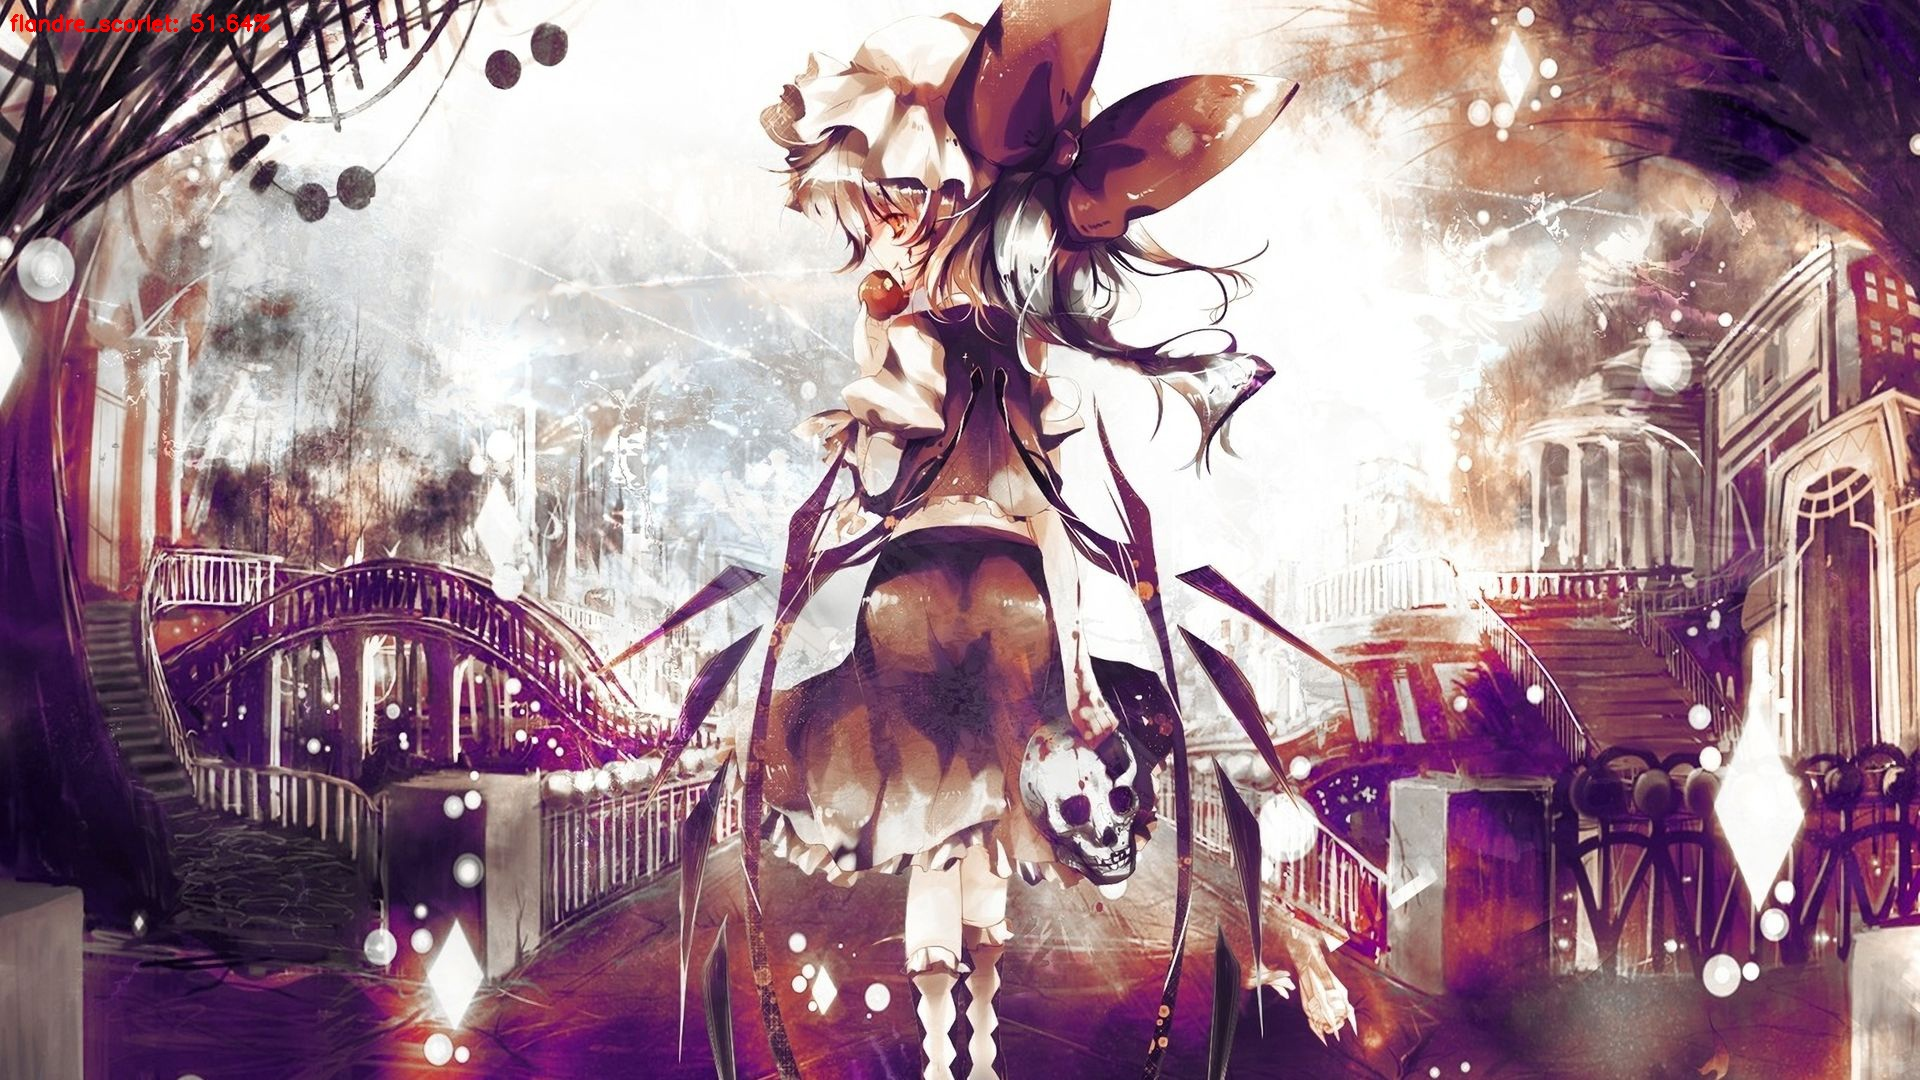

In [117]:
predict_image('./tests/flandre_scarlet/2.jpg', model, lb)
Image('output.jpg')